# Calculating DRT

This package estimates DRT by generating a Voigt circuit model and fitting its parameters using `LsqFit.jl`. The concept can be broken down simply: any impedance $Z(\omega)$ can be generated by a series of RC pairs:
$$
Z(\omega) = \sum_i^\infty \frac{R_i}{1+i\omega\tau_i},\\ \tau_i = R_iC_i
$$
This is analogous to a fourier transform for generic functions. Let's look at some examples.

In [1]:
using EISAnalysis

First, let's consider a simple circuit with 2 RC pairs

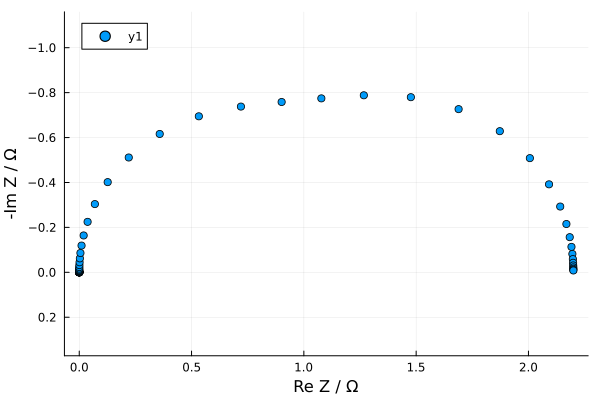

In [2]:
rc_circuit = r/c-1.2r/5c
plot_Nyquist(rc_circuit)

You can fit this to a Voigt circuit and estimate the DRT. The expanded fit includes the individual contribution from each RC pair in the Voigt circuit model and acts as a visual aid in interpreting the DRT plot.

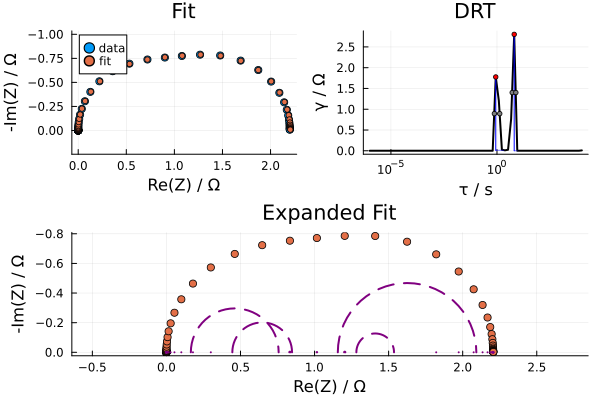

rtol = 9.753554486139811e-5


Dict{String, Any} with 4 entries:
  "Z"   => ComplexF64[1.08262e-10-1.2154e-5im, 2.09021e-10-1.68879e-5im, 4.0355…
  "τ"   => LogRange{Float64}(1.0e-6, 10000.0, 70)
  "R0"  => 0.0
  "drt" => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0,…

In [ ]:
rc_fit = compute_drt(rc_circuit.ω,rc_circuit.Z)

Constant-phase elements are used to capture capacative (non-faradaic) processes which are non-ideal, and this is reflected in the gaussian shape of the DRT.

rtol = 1.3210511534332157e-14


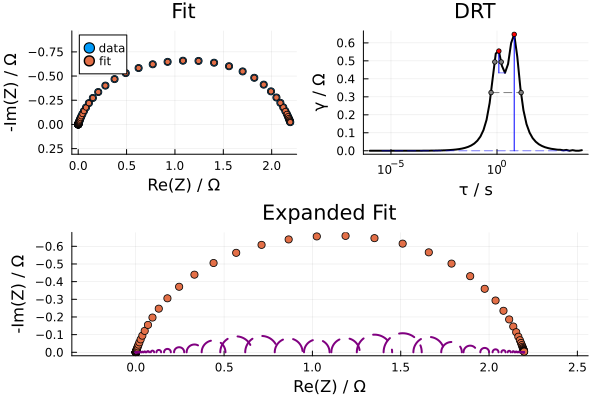

Dict{String, Any} with 4 entries:
  "Z"   => ComplexF64[3.94376e-5-0.000121343im, 5.13126e-5-0.000157868im, 6.676…
  "τ"   => LogRange{Float64}(1.0e-6, 10000.0, 70)
  "R0"  => 1.80035e-6
  "drt" => [1.7049e-5, 7.79661e-7, 9.44932e-7, 1.6376e-5, 0.0, 2.68542e-5, 8.40…

In [ ]:
rq_circuit = r/q-1.2r/5q
rq_fit = compute_drt(rq_circuit.ω,rq_circuit.Z)

Now for more complicated circuits, it is helpful to employ Tikhonov regularization to decouple parameters. However, one has to be carefel when interpreting this data. Notice the high frequency (low timescale) bump in the fit as well as the DRT. This is an artifact from the regularization method. It's always helpful to see the results both with and without regularization to check for such artifacts.

In general, computing the DRT is problematic when the EIS frequency range is too narrow and the Nyquist plot is not fully resolved (especially on the high frequency end). In such cases it is safer to use `circuit_fit`.

Regularization
--------------
λ = 9.999999999999999e-5
rtol = 0.0005431364784255923


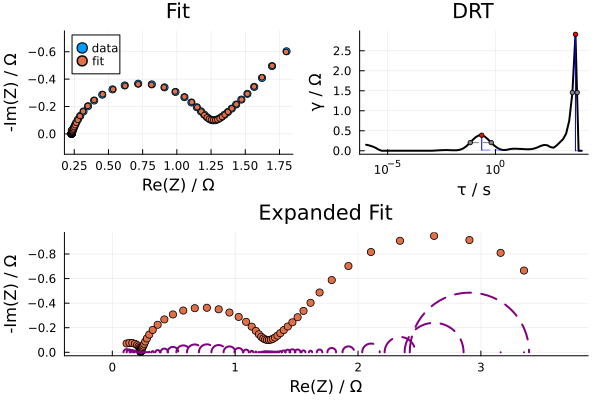

Dict{String, Any} with 4 entries:
  "Z"   => ComplexF64[0.225575-0.0277721im, 0.228226-0.0205447im, 0.229664-0.01…
  "τ"   => LogRange{Float64}(1.0e-6, 10000.0, 70)
  "R0"  => 0.0648194
  "drt" => [0.150936, 0.133404, 0.108899, 0.075177, 0.0303512, 0.0, 0.0, 0.0, 0…

In [8]:
randles_circuit = 0.23r-(r-0.025ws^80)/0.2q
randles_fit = compute_drt(randles_circuit.ω,randles_circuit.Z;regularization=true)

With this experimental EIS data from Mendeley, the issue discussed above is further demonstrated. 

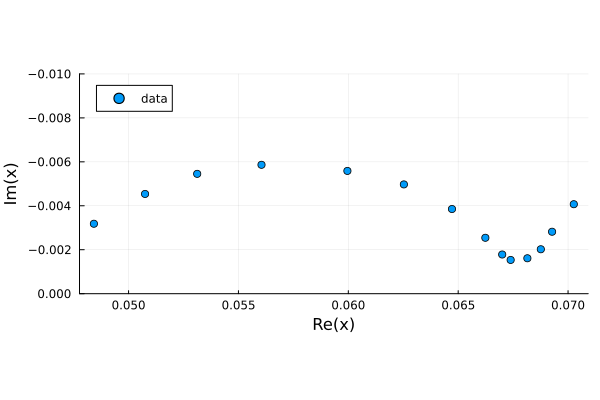

In [9]:
using CSV,DataFrames,Plots
ω_exp =  [ 0.05, 0.1, 0.2, 0.4, 1, 2, 4, 10, 20, 40, 100, 200, 400, 1000]
data = CSV.read("Data/EIS_Data.csv",DataFrame)
Z_exp = data[!,"Re(Z)"]-im*data[!,"-Im(Z)"]
plt =scatter(Z_exp,label = "data",aspect_ratio=:equal)
plot!(plt,ylims = (-0.01,0),yflip=true)

Without using regularization we may have a good DRT firt but may wish to use regularization to decouple the parameters and generate a smoother function. However the drt computed with regularization generates a model that does not fit at all to the original data set. This is principally owed to the unresolved feature of the original Nyquist plot in the high frequency range. In this case it could me more useful to fit the data to a circuit model like a Randles circuit.

rtol = 5.899319460523529e-7
Regularization
--------------
λ = 0.01
rtol = 0.0008280857326777196


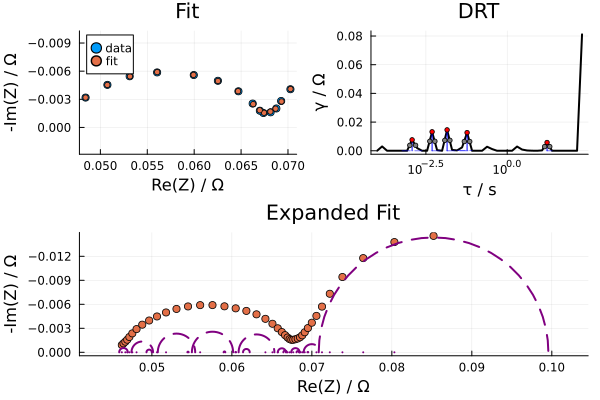

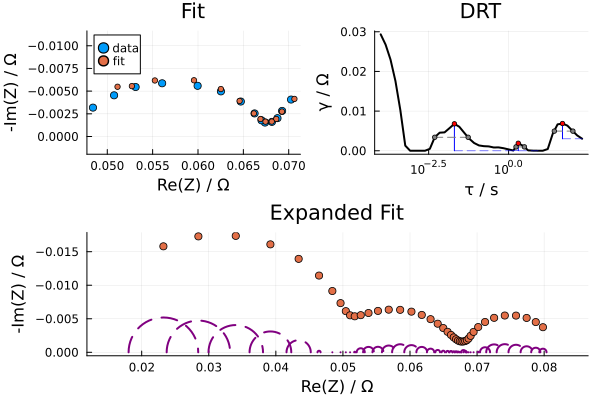

Dict{String, Any} with 4 entries:
  "Z"   => ComplexF64[0.0706284-0.00414218im, 0.0692506-0.00274757im, 0.0686266…
  "τ"   => LogRange{Float64}(0.0001, 200.0, 42)
  "R0"  => 0.0124534
  "drt" => [0.0293391, 0.0267395, 0.022969, 0.0175789, 0.0102225, 0.00129367, 0…

In [11]:
fit = compute_drt(ω_exp,Z_exp)
regularized_fit = compute_drt(ω_exp,Z_exp;regularization=true)